## Neural Network comparison
In this notebook three different convolutional neural networks are built and trained on the same CIFAR-10 dataset.

1. The first 'default' network is built according to the provided base architecture.
2. The second network is a modified version of the 'default' network where the nonlinearity functions of the convolutional layers are changed to sigmoid.
3. The last network is modified in the same way but with the ELU nonlinearities.

As expected, the 'sigmoid' network performed the worst. Its loss convergence is close to linear and did not produce a good rate after 100 epochs (55% accuracy). The 'default' (Leaky ReLU) and 'ELU' networks both converged to a similar state rather quickly but failed to achieve good results overall, staying at ~65% accuracy during test time.

The process of the network building and training is presented below.

## Preparing the data

In [1]:
import numpy as np
from cifar import load_cifar10

# load cifar-10 dataset
X_train, y_train, X_val, y_val, X_test, y_test = load_cifar10("cifar_data")

In [2]:
import theano
import theano.tensor as T
import lasagne

# input data
input_X = T.tensor4("input X")

# input dimension
input_shape = [None,3,32,32]

# target labels
target_y = T.vector("target Y", dtype='int32')

## Building the network

Default network architecture

In [3]:
comp_scale = 8  # computational resources parameter

# GlorotUniform is the default weights initialization
# 0.01 is the default leakiness for leaky_rectify nonlinearity

input_layer = lasagne.layers.InputLayer(shape = input_shape, 
                                        input_var = input_X, 
                                        name = 'input')

conv_1 = lasagne.layers.Conv2DLayer(input_layer, 
                                    num_filters = comp_scale, 
                                    filter_size = (3, 3), 
                                    nonlinearity = lasagne.nonlinearities.leaky_rectify, 
                                    name = 'conv_1')

conv_2 = lasagne.layers.Conv2DLayer(conv_1, 
                                    num_filters = comp_scale, 
                                    filter_size = (3, 3), 
                                    nonlinearity = lasagne.nonlinearities.leaky_rectify, 
                                    name = 'conv_2')

max_pool_1 = lasagne.layers.MaxPool2DLayer(conv_2, 
                                           pool_size = 2, 
                                           name = 'max_pool_1')

conv_3 = lasagne.layers.Conv2DLayer(max_pool_1, 
                                    num_filters = int(comp_scale * 1.5), 
                                    filter_size = (3, 3), 
                                    nonlinearity = lasagne.nonlinearities.leaky_rectify, 
                                    name = 'conv_3')

conv_4 = lasagne.layers.Conv2DLayer(conv_3, 
                                    num_filters = int(comp_scale * 1.5), 
                                    filter_size = (3, 3), 
                                    nonlinearity = lasagne.nonlinearities.leaky_rectify, 
                                    name = 'conv_4')

max_pool_2 = lasagne.layers.MaxPool2DLayer(conv_4, 
                                           pool_size = 2, 
                                           name = 'max_pool_2')

conv_5 = lasagne.layers.Conv2DLayer(max_pool_2, 
                                    num_filters = comp_scale * 2, 
                                    filter_size = (3, 3), 
                                    nonlinearity = lasagne.nonlinearities.leaky_rectify, 
                                    name = 'conv_5')

conv_6 = lasagne.layers.Conv2DLayer(conv_5, 
                                    num_filters = comp_scale * 2, 
                                    filter_size = (3, 3), 
                                    nonlinearity = lasagne.nonlinearities.leaky_rectify, 
                                    name = 'conv_6')

global_pool = lasagne.layers.GlobalPoolLayer(conv_6, 
                                             name = 'global_pool')

dense_output = lasagne.layers.DenseLayer(global_pool, 
                                         num_units = 10, 
                                         nonlinearity = lasagne.nonlinearities.softmax, 
                                         name = 'output')

In [4]:
y_predicted = lasagne.layers.get_output(dense_output)

all_weights = lasagne.layers.get_all_params(dense_output, trainable=True)

loss = lasagne.objectives.categorical_crossentropy(y_predicted, target_y).mean()

accuracy = lasagne.objectives.categorical_accuracy(y_predicted, target_y).mean()


# weights update
updates = lasagne.updates.adamax(loss, all_weights)


# a function that accepts X and y, returns loss functions and performs weight updates
train_fun = theano.function([input_X, target_y], [loss, accuracy], updates = updates)


# deterministic prediciton
y_predicted_det = lasagne.layers.get_output(dense_output, deterministic = True)

# deterministic accuracy
accuracy_det = lasagne.objectives.categorical_accuracy(y_predicted_det, target_y).mean()

# function that computes that accuracy
accuracy_fun = theano.function([input_X, target_y], accuracy_det)

## Auxiliary functions

In [5]:
def iterate_minibatches(X, y, batchsize):    
    '''Return an iterable of (X_batch, y_batch) batches of images and answers for them.'''
    
    size = len(X)
    indices = np.arange(size)
    np.random.shuffle(indices)
    
    for start_idx in range(0, size, batchsize):
        excerpt = indices[start_idx : start_idx + batchsize]
        yield X[excerpt], y[excerpt]

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

def update_progress(epoch, num_epochs, 
                  time_since_update, duration, 
                  train_err, train_acc, val_acc, 
                  train_batches, val_batches, 
                  log):
    '''Display training progress. Update every second.'''
    
    # should be if log len is num_epochs or smth
    if epoch < num_epochs - 1:
        if train_batches > 0:
            log.append([train_err/train_batches, train_err, train_acc, val_acc, train_batches, val_batches, duration])
        else:
            log.append([0, train_err, train_acc, val_acc, train_batches, val_batches, duration])

    if time_since_update > 1:
        
        clear_output(True)

        print("Epoch {} of {} took {:.3f} s".format(epoch + 1, num_epochs, duration))
        print("  training loss:\t\t{:.6f}".format(train_err / train_batches))
        print("  train accuracy:\t\t{:.2f} %".format(train_acc / train_batches * 100))
        print("  validation accuracy:\t\t{:.2f} %".format(val_acc / val_batches * 100))

        plt.figure(figsize=[8,4])
        plt.plot(zip(*log)[0], label='Loss')
        plt.ylim(0, 2.5)
        plt.legend(loc='best')
        plt.grid()
        time_since_update = 0

        plt.show()
    
    return time_since_update

In [7]:
import time

def train_network(num_epochs, batch_size, log, X_train, y_train, X_val, y_val, X_test, y_test):
    '''Perform training of a network.'''
    
    time_since_update = 0

    for epoch in range(num_epochs):
        # do a full pass over the training data
        train_err = 0
        train_acc = 0
        train_batches = 0
        start_time = time.time()
        for batch in iterate_minibatches(X_train, y_train, batch_size):
            inputs, targets = batch
            train_err_batch, train_acc_batch= train_fun(inputs, targets)
            train_err += train_err_batch
            train_acc += train_acc_batch
            train_batches += 1

        # do a full pass over the validation data
        val_acc = 0
        val_batches = 0
        for batch in iterate_minibatches(X_val, y_val, batch_size):
            inputs, targets = batch
            val_acc += accuracy_fun(inputs, targets)
            val_batches += 1

        time_since_update += time.time() - start_time
        time_since_update = update_progress(epoch, num_epochs, 
                                            time_since_update, 
                                            time.time() - start_time, 
                                            train_err, train_acc, val_acc, 
                                            train_batches, val_batches, 
                                            log)

    # log == [train_err/train_batches, train_err, train_acc, val_acc, train_batches, val_batches, duration]

    last_entry = log[-1]  # plot the last epoch in case it didn't show

    time_since_update = update_progress(num_epochs - 1, num_epochs, 
                                        2, 
                                        last_entry[-1], 
                                        last_entry[1], last_entry[2], last_entry[3], 
                                        last_entry[4], last_entry[5], 
                                        log)
    # evaluate on the test data
    test_acc = 0
    test_batches = 0
    for batch in iterate_minibatches(X_test, y_test, 500):
        inputs, targets = batch
        acc = accuracy_fun(inputs, targets)
        test_acc += acc
        test_batches += 1
    print("Final results:")
    print("  test accuracy:\t\t{:.2f} %".format(test_acc / test_batches * 100))
    print

## Sanity checks

#### Checking that the loss is reasonable
Loss should be ~2.3 without any regularization.

In [137]:
check_input, check_target = iterate_minibatches(X_train, y_train, 50).next()
check_loss, check_acc = train_fun(check_input, check_target)
print check_loss

2.31379168307


#### Making sure we can overfit a small portion of the data
i.e. get ~0 loss and ~100% accuracy.

Epoch 100 of 100 took 0.071 s
  training loss:		0.003688
  train accuracy:		100.00 %
  validation accuracy:		100.00 %


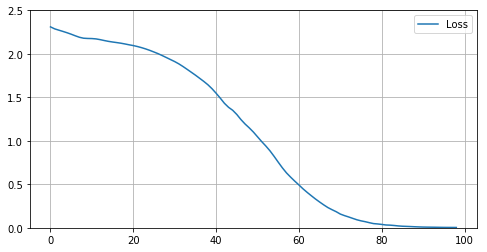

Final results:
  test accuracy:		100.00 %

CPU times: user 10.7 s, sys: 948 ms, total: 11.7 s
Wall time: 12.3 s


In [47]:
%%time

X_tiny = X_train[:20]
y_tiny = y_train[:20]

log_tiny = [] #[train_err/train_batches, train_err, train_acc, val_acc, train_batches, val_batches, duration]

train_network(100, 20, log_tiny, X_tiny, y_tiny, X_tiny, y_tiny, X_tiny, y_tiny)

## Training the default network
Network weights are reinitialized beforehand.

Epoch 100 of 100 took 116.528 s
  training loss:		0.806457
  train accuracy:		71.11 %
  validation accuracy:		66.16 %


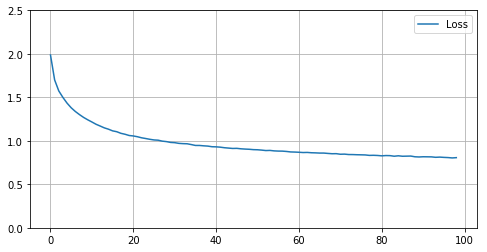

Final results:
  test accuracy:		65.17 %

CPU times: user 3h 19min 19s, sys: 19min 21s, total: 3h 38min 40s
Wall time: 3h 15min 5s


In [8]:
%%time

log_default = []

train_network(100, 50, log_default, X_train, y_train, X_val, y_val, X_test, y_test)

In [9]:
# save the network weights to a file
np.savez('network_default.npz', *lasagne.layers.get_all_param_values(conv_1))

# to load them again later on:
# with np.load('network_default.npz') as f:
#     param_values = [f['arr_%d' % i] for i in range(len(f.files))]
# lasagne.layers.set_all_param_values(network, param_values)

In [20]:
# save the training log to a file
np.save('log_default.npy', log_default)

## Modified network 1
Nonlinearity of conv layers is changed to sigmoid.

In [10]:
comp_scale = 8

# GlorotUniform is the default weights initialization

input_layer = lasagne.layers.InputLayer(shape = input_shape, 
                                        input_var = input_X, 
                                        name = 'input')

conv_1 = lasagne.layers.Conv2DLayer(input_layer, 
                                    num_filters = comp_scale, 
                                    filter_size = (3, 3), 
                                    nonlinearity = lasagne.nonlinearities.sigmoid, 
                                    name = 'conv_1')

conv_2 = lasagne.layers.Conv2DLayer(conv_1, 
                                    num_filters = comp_scale, 
                                    filter_size = (3, 3), 
                                    nonlinearity = lasagne.nonlinearities.sigmoid, 
                                    name = 'conv_2')

max_pool_1 = lasagne.layers.MaxPool2DLayer(conv_2, 
                                           pool_size = 2, 
                                           name = 'max_pool_1')

conv_3 = lasagne.layers.Conv2DLayer(max_pool_1, 
                                    num_filters = int(comp_scale * 1.5), 
                                    filter_size = (3, 3), 
                                    nonlinearity = lasagne.nonlinearities.sigmoid, 
                                    name = 'conv_3')

conv_4 = lasagne.layers.Conv2DLayer(conv_3, 
                                    num_filters = int(comp_scale * 1.5), 
                                    filter_size = (3, 3), 
                                    nonlinearity = lasagne.nonlinearities.sigmoid, 
                                    name = 'conv_4')

max_pool_2 = lasagne.layers.MaxPool2DLayer(conv_4, 
                                           pool_size = 2, 
                                           name = 'max_pool_2')

conv_5 = lasagne.layers.Conv2DLayer(max_pool_2, 
                                    num_filters = comp_scale * 2, 
                                    filter_size = (3, 3), 
                                    nonlinearity = lasagne.nonlinearities.sigmoid, 
                                    name = 'conv_5')

conv_6 = lasagne.layers.Conv2DLayer(conv_5, 
                                    num_filters = comp_scale * 2, 
                                    filter_size = (3, 3), 
                                    nonlinearity = lasagne.nonlinearities.sigmoid, 
                                    name = 'conv_6')

global_pool = lasagne.layers.GlobalPoolLayer(conv_6, 
                                             name = 'global_pool')

dense_output = lasagne.layers.DenseLayer(global_pool, 
                                         num_units = 10, 
                                         nonlinearity = lasagne.nonlinearities.softmax, 
                                         name = 'output')

In [11]:
y_predicted = lasagne.layers.get_output(dense_output)

all_weights = lasagne.layers.get_all_params(dense_output, trainable=True)

loss = lasagne.objectives.categorical_crossentropy(y_predicted, target_y).mean()

accuracy = lasagne.objectives.categorical_accuracy(y_predicted, target_y).mean()


# weights update
updates = lasagne.updates.adamax(loss, all_weights)


# a function that accepts X and y, returns loss functions and performs weight updates
train_fun = theano.function([input_X, target_y], [loss, accuracy], updates = updates)


# deterministic prediciton
y_predicted_det = lasagne.layers.get_output(dense_output, deterministic = True)

# deterministic accuracy
accuracy_det = lasagne.objectives.categorical_accuracy(y_predicted_det, target_y).mean()

# function that computes that accuracy
accuracy_fun = theano.function([input_X, target_y], accuracy_det)

Epoch 100 of 100 took 126.136 s
  training loss:		1.217453
  train accuracy:		56.22 %
  validation accuracy:		55.44 %


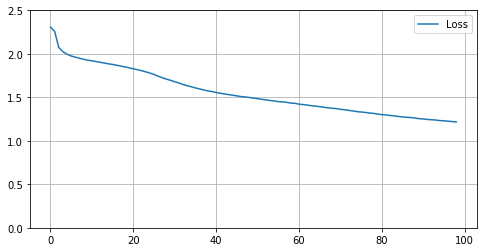

Final results:
  test accuracy:		55.42 %

CPU times: user 3h 39min 14s, sys: 16min 8s, total: 3h 55min 22s
Wall time: 3h 31min 32s


In [12]:
%%time

log_sigmoid = []

train_network(100, 50, log_sigmoid, X_train, y_train, X_val, y_val, X_test, y_test)

In [13]:
np.savez('network_sigmoid.npz', *lasagne.layers.get_all_param_values(conv_1))

In [26]:
np.save('log_sigmoid.npy', log_sigmoid)

## Modified network 2
Nonlinearity of conv layers is changed to ELU.

In [14]:
comp_scale = 8

# GlorotUniform is the default weights initialization

input_layer = lasagne.layers.InputLayer(shape = input_shape, 
                                        input_var = input_X, 
                                        name = 'input')

conv_1 = lasagne.layers.Conv2DLayer(input_layer, 
                                    num_filters = comp_scale, 
                                    filter_size = (3, 3), 
                                    nonlinearity = lasagne.nonlinearities.elu, 
                                    name = 'conv_1')

conv_2 = lasagne.layers.Conv2DLayer(conv_1, 
                                    num_filters = comp_scale, 
                                    filter_size = (3, 3), 
                                    nonlinearity = lasagne.nonlinearities.elu, 
                                    name = 'conv_2')

max_pool_1 = lasagne.layers.MaxPool2DLayer(conv_2, 
                                           pool_size = 2, 
                                           name = 'max_pool_1')

conv_3 = lasagne.layers.Conv2DLayer(max_pool_1, 
                                    num_filters = int(comp_scale * 1.5), 
                                    filter_size = (3, 3), 
                                    nonlinearity = lasagne.nonlinearities.elu, 
                                    name = 'conv_3')

conv_4 = lasagne.layers.Conv2DLayer(conv_3, 
                                    num_filters = int(comp_scale * 1.5), 
                                    filter_size = (3, 3), 
                                    nonlinearity = lasagne.nonlinearities.elu, 
                                    name = 'conv_4')

max_pool_2 = lasagne.layers.MaxPool2DLayer(conv_4, 
                                           pool_size = 2, 
                                           name = 'max_pool_2')

conv_5 = lasagne.layers.Conv2DLayer(max_pool_2, 
                                    num_filters = comp_scale * 2, 
                                    filter_size = (3, 3), 
                                    nonlinearity = lasagne.nonlinearities.elu, 
                                    name = 'conv_5')

conv_6 = lasagne.layers.Conv2DLayer(conv_5, 
                                    num_filters = comp_scale * 2, 
                                    filter_size = (3, 3), 
                                    nonlinearity = lasagne.nonlinearities.elu, 
                                    name = 'conv_6')

global_pool = lasagne.layers.GlobalPoolLayer(conv_6, 
                                             name = 'global_pool')

dense_output = lasagne.layers.DenseLayer(global_pool, 
                                         num_units = 10, 
                                         nonlinearity = lasagne.nonlinearities.softmax, 
                                         name = 'output')

In [15]:
y_predicted = lasagne.layers.get_output(dense_output)

all_weights = lasagne.layers.get_all_params(dense_output, trainable=True)

loss = lasagne.objectives.categorical_crossentropy(y_predicted, target_y).mean()

accuracy = lasagne.objectives.categorical_accuracy(y_predicted, target_y).mean()


# weights update
updates = lasagne.updates.adamax(loss, all_weights)


# a function that accepts X and y, returns loss functions and performs weight updates
train_fun = theano.function([input_X, target_y], [loss, accuracy], updates = updates)


# deterministic prediciton
y_predicted_det = lasagne.layers.get_output(dense_output, deterministic = True)

# deterministic accuracy
accuracy_det = lasagne.objectives.categorical_accuracy(y_predicted_det, target_y).mean()

# function that computes that accuracy
accuracy_fun = theano.function([input_X, target_y], accuracy_det)

Epoch 100 of 100 took 134.463 s
  training loss:		0.736262
  train accuracy:		74.00 %
  validation accuracy:		66.87 %


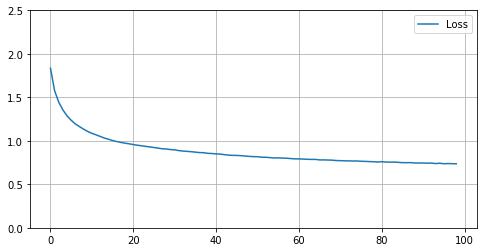

Final results:
  test accuracy:		65.68 %

CPU times: user 3h 49min 4s, sys: 18min 39s, total: 4h 7min 44s
Wall time: 3h 43min 56s


In [16]:
%%time

log_elu = []

train_network(100, 50, log_elu, X_train, y_train, X_val, y_val, X_test, y_test)

In [17]:
np.savez('network_elu.npz', *lasagne.layers.get_all_param_values(conv_1))

In [27]:
np.save('log_elu.npy', log_elu)